<div class="jumbotron text-left"><b>
    
This tutorial shows the importance to re interpolate the variance in the case of noisy Gaussian Processes to perform some Bayesian Optimization.
<div>
    
Nathalie BARTOLI, Paul SAVES and Maël TREMOUILLE ONERA/DTIS/M2CI
    
July  2024 - SMT version 2.9.0

In [38]:
# %pip install smt

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference book is available for the re interpolation formulas in the book  `Forrester, A., Sobester, A., & Keane, A. (2008). Engineering design via surrogate modelling: a practical guide. John Wiley & Sons.`


<div class="alert alert-info fade in" id="d110">
<p>In this notebook, two examples are presented to illustrate Bayesian Optimization in the case of noisy Gaussian processes</p>
<ol> - a 1D-example (xsinx function) to illustrate the limits of EGO for noisy Gaussian Processes without re interpolation of the variance </ol>
<ol> - a 2D-exemple (Rosenbrock function) where the EGO is applied with a re interpolation  </ol>    
</div>

In [39]:
# to avoid warning messages
import warnings

warnings.filterwarnings("ignore")

## 1. Bayesian optimization with the xsinx example: 1D

First, let's examine the simplest case of Kriging in 1D with a well-known function. It is useful to reintroduce the idea of noise-free Kriging and how the variance is equal to 0 for  training points.

### 1.1 xsinx function and DOE

In [40]:
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


def fun_1d(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))

Number of DOE points =  3


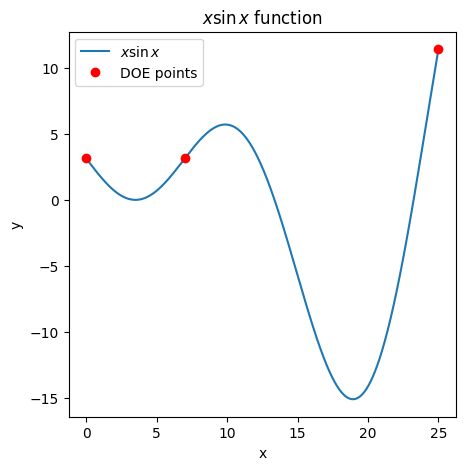

In [41]:
X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun_1d(X_plot)
# Tracer la fonction
lines = []
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot, label=r"$x \sin{x}$")
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Ajouter les points DOE
xdoe = np.atleast_2d([0, 7, 25]).T
ydoe = fun_1d(xdoe)
n_doe = xdoe.shape[0]
print("Number of DOE points = ", n_doe)

# Tracer les points DOE sur le graphique
doe_points = ax.plot(
    xdoe, ydoe, "ro", label="DOE points"
)  # 'ro' pour des points rouges
lines.append(doe_points)

# Ajouter une légende
ax.legend()

# Afficher le graphique
plt.show()

### 1.2. Noise-free kriging

Build the GP model with a square exponential kernel with SMT toolbox knowing $(x_{data}, y_{data})$.

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...


   Training - done. Time (sec):  0.1775701


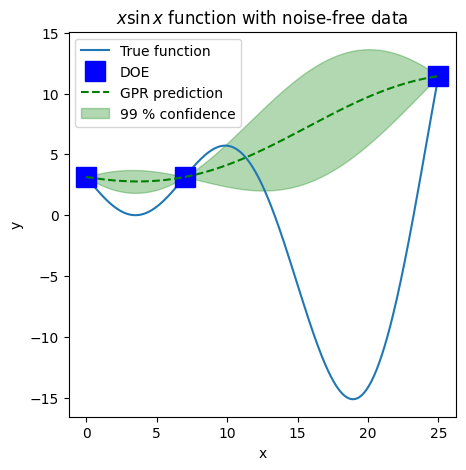

In [42]:
from smt.surrogate_models import KRG

# dimension of the problem
ndim = 1

########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2] * ndim, print_prediction=False, corr="squar_exp")

# Training
t.set_training_values(xdoe, ydoe)
t.train()
# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, doe, gp, un_gp]
ax.set_title(r"$x \sin{x}$ function with noise-free data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "DOE", "GPR prediction", "99 % confidence"])
plt.show()

We can clearly see that in the case of noise-free data, the variance is equal to 0 at the training points.

In [43]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS
from smt.design_space import (
    DesignSpace,
)

### 1.3. Noisy Kriging: the main issue with EGO
We can take a look at what happens if we apply EGO it in the classical way in the case of noisy Kriging.

Parameters that we can play on:

In [44]:
n_iter = 8  # the number of points one wants to infill to find the minimum
xlimits = np.array([[0.0, 25.0]])
random_state = 42  # for reproducibility
noise0 = [2e-1]  # if one wants to add a noise at the variance of data points
eval_noise = False  # if one wants to evaluate the noise at each data point
enable_tunneling = False  # if one wants to add a penalisation for the EI criterion
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
n_start = 20
# Model
design_space = DesignSpace(xlimits, random_state=random_state)
surrogate = KRG(
    design_space=design_space,
    print_global=False,
    noise0=noise0,
    eval_noise=eval_noise,
)

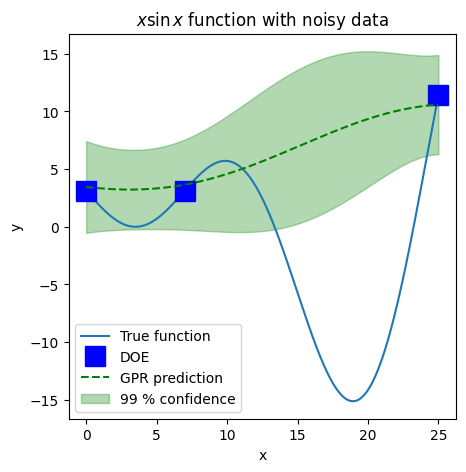

In [45]:
# Plot the initial DOE and the associated noisy Kriging

# Training
surrogate.set_training_values(xdoe, ydoe)
surrogate.train()
# Prediction of the  points for the plot
Y_GP_plot = surrogate.predict_values(X_plot)
Y_GP_plot_var = surrogate.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, doe, gp, un_gp]
ax.set_title(r"$x \sin{x}$ function with noisy data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "DOE", "GPR prediction", "99 % confidence"])
plt.show()

Minimum in x=3.6 with f(x)=0.0


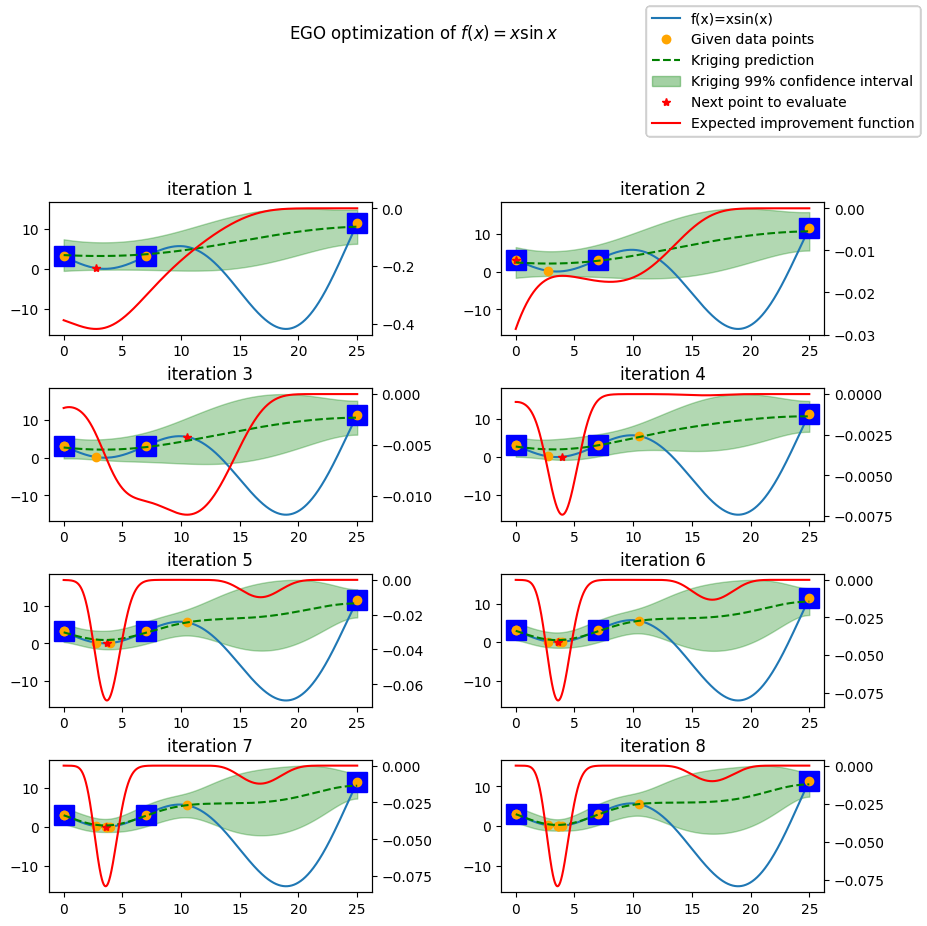

In [46]:
# Application of EGO
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=surrogate,
    random_state=random_state,
    enable_tunneling=enable_tunneling,
    n_start=n_start,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun_1d)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(x_opt.item(), y_opt.item()))


fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(X_plot)
    y_gp_plot_var = ego.gpr.predict_variances(X_plot)
    y_ei_plot = -ego.EI(
        points=X_plot, enable_tunneling=enable_tunneling, x_data=x_data_k
    )
    # print(f"min {i+1}", y_ei_plot[0])
    # print(f"{i+1}ème itétation valeur EI minimale:", min(y_ei_plot))
    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(X_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(X_plot, Y_plot)
    # (doe,) = ax.plot(
    # xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue"
    # )
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    if i < n_iter - 1:
        (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(X_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \\sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvement function",
        ],
    )
plt.show()
# Check the optimal point is x_opt=18.9, y_opt =-15.1

We clearly see that exploring more does not allow the algorithm to reduce the EI criterion properly to look elsewhere: the algorithm converges to the local minimum and stagnates around 3. This is why it is an interesting idea to re-interpolate the variance at training (and also explored) points.

### 1.4. Re-interpolation case

#### 1.4.1. Concepts

Here, the idea developed by Forrester et al. in his book quoted above. <br>
In **noise-free** Kriging, $\hat{s}^2$ can be computed this way: <br>
$$
\hat{s}^2(\mathbf{x}) = \hat\sigma^2 \left[ 1 - \psi^\top \Psi^{-1} \psi + \frac{1 - \mathbf{1}^\top \Psi^{-1} \psi}{\mathbf{1}^\top \Psi^{-1} \mathbf{1}} \right]
$$
with
$$
\hat{\sigma}^2= \frac{(\mathbf{y} - \mathbf{1} \hat{\mu})^{T}\Psi^{-1}(\mathbf{y} - \mathbf{1} \hat{\mu})}{n} \quad  \text{and} \quad \hat{\mu} = \frac{\mathbf{1}^{T}\Psi^{-1}\mathbf{y}}{\mathbf{1}^{T}\Psi^{-1}\mathbf{1}}
$$

*   $n$ is the number of points in the DOE
*   $\mathbf{x}$ is the point where one wants the prediction
*   $\mathbf{y}$ is the vector of observed responses for the sample data 
*   $\hat\mu$ is the predicted mean
*   $\Psi$ $n \times n$ Correlation matrix
*   $\psi$ is a vector of the correlations between each point in the data set and the point $x$

If we are calculating $\hat{s}^2(\mathbf{x})$ at a sample point $\mathbf{x}^i$, $\psi$ is the ith column of $\Psi$. Thus $\psi^\top \Psi^{-1} \psi=1$ and $1^\top \Psi^{-1} \psi=1$ lead to $\hat{s}^2(\mathbf{x}^i)=0$.

But, in the case of **noisy** Kriging, it turns out that the calculation is a bit different because of the correlation matrix $\Psi$ which becomes $\Psi + \lambda I$, where $\lambda$ is a regression constant added to the leading diagonal of $\Psi$. So at a sample point $\mathbf{x}^i$ $\psi$ is never a  column of $\Psi$ and so the data is not interpolated.

Actually, we get: <br>
$$
\hat{s}^2_r(\mathbf{x}) = \hat{\sigma}^2_r \left[ 1 + \lambda - \psi^\top (\Psi + \lambda I)^{-1} \psi + \frac{1 - \mathbf{1}^\top (\Psi + \lambda I)^{-1} \psi}{\mathbf{1}^\top (\Psi + \lambda I)^{-1} \mathbf{1}} \right]
$$
$$
\text{where} \quad \hat{\sigma}^2_r = \frac{(\mathbf{y} - \mathbf{1} \hat{\mu}_r)^{T}(\Psi + \lambda I)^{-1}(\mathbf{y} - \mathbf{1} \hat{\mu}_r)}{n} \quad  \text{and} \quad \hat{\mu}_{r} = \frac{\mathbf{1}^{T}(\Psi + \lambda I)^{-1}\mathbf{y}}{\mathbf{1}^{T}(\Psi + \lambda I)^{-1}\mathbf{1}}
$$

Since the calculation of EI depends on these estimations, it has repercussions on EI because the algorithm can now infill points that we already have measured. To get around the problem, Forrester et al. proposed to re-interpolate $\hat{\sigma}^2$ and to plug it into $\hat{s}^2$. We then get:
$$
\hat{\sigma}^2_{ri} = \frac{(\mathbf{y} - \mathbf{1} \hat{\mu})^{T}(\Psi + \lambda I)^{-1}\Psi(\Psi + \lambda I)^{-1}(\mathbf{y} - \mathbf{1} \hat{\mu})}{n}
$$
$$
\text{and then} \quad \hat{s}^2_{ri}(\mathbf{x}) = \hat{\sigma}^2_{ri} \left[ 1 - \psi^\top \Psi^{-1} \psi + \frac{1 - \mathbf{1}^\top \Psi^{-1} \psi}{\mathbf{1}^\top \Psi^{-1} \mathbf{1}} \right]
$$



Once implemented, we call this feature through the parameter `is_ri`, which means *is re-interpolated*.

We can then apply the new feature `is_ri`, namely the re-interpolation of the variance, which leads to a null EI at training points. As we will notice, it is supposed to prevent the algorithm from stagnating due to the enrichment in the EI criterion.

#### 1.4.2. Comparison of variances with or without Re-Interpolation

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0929203
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1534348


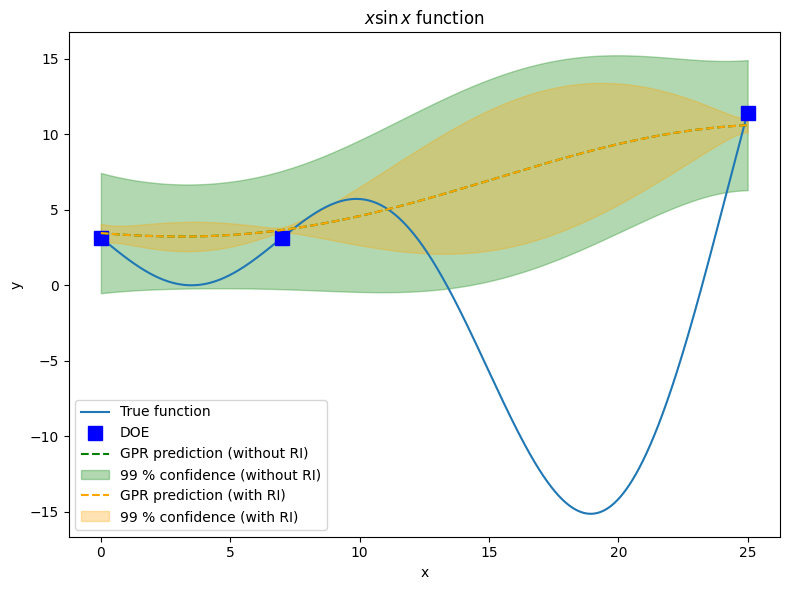

In [47]:
# Dimension of the problem
ndim = 1

# Kriging model setup with noise
noise0 = [2e-1]
theta0 = [1e-2] * ndim

t_noisy = KRG(theta0=theta0, noise0=noise0, print_prediction=False, corr="squar_exp")

# Training
t_noisy.set_training_values(xdoe, ydoe)
t_noisy.train()

# Prediction of the points for the plot
Y_GP_plot = t_noisy.predict_values(X_plot)

# Variance without re-interpolation
Y_GP_plot_var = t_noisy.predict_variances(X_plot, is_ri=False)
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)

t_noisy_ri = KRG(
    theta0=theta0, noise0=noise0, print_prediction=False, corr="squar_exp", is_ri=True
)

# Training
t_noisy_ri.set_training_values(xdoe, ydoe)
t_noisy_ri.train()

# Variance with re-interpolation
Y_GP_plot_var_ri = t_noisy_ri.predict_variances(X_plot, is_ri=True)
sig_plus_ri = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var_ri)
sig_moins_ri = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var_ri)

# Plotting
fig, ax = plt.subplots(figsize=[8, 6])

# True function
(true_fun,) = ax.plot(X_plot, Y_plot, label="True function")

# Design of experiment
(doe,) = ax.plot(
    xdoe, ydoe, linestyle="", marker="s", markersize=10, color="blue", label="DOE"
)

# GPR prediction without re-interpolation
(gp,) = ax.plot(
    X_plot, Y_GP_plot, linestyle="--", color="g", label="GPR prediction (without RI)"
)
un_gp = ax.fill_between(
    X_plot.T[0],
    sig_plus.T[0],
    sig_moins.T[0],
    alpha=0.3,
    color="g",
    label="99 % confidence (without RI)",
)

# GPR prediction with re-interpolation
(gp_ri,) = ax.plot(
    X_plot, Y_GP_plot, linestyle="--", color="orange", label="GPR prediction (with RI)"
)
un_gp_ri = ax.fill_between(
    X_plot.T[0],
    sig_plus_ri.T[0],
    sig_moins_ri.T[0],
    alpha=0.3,
    color="orange",
    label="99 % confidence (with RI)",
)

# General plot setup
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.tight_layout()
plt.show()
plt.show()

In [48]:
print(
    f"with re-interpolation we get a variance at xdoe < 0.1 {t_noisy_ri.predict_variances(xdoe, is_ri=True) < 1e-1}"
)
print(
    f"without re-interpolation we get a variance at xdoe > 1 {t_noisy.predict_variances(xdoe, is_ri=False) > 1}"
)

with re-interpolation we get a variance at xdoe < 0.1 [[ True]
 [ True]
 [ True]]
without re-interpolation we get a variance at xdoe > 1 [[ True]
 [ True]
 [ True]]


#### 1.4.3. Application with EGO

In [49]:
# To use or not re-interpolation
is_ri = True

Minimum in x=18.4 with f(x)=-14.9


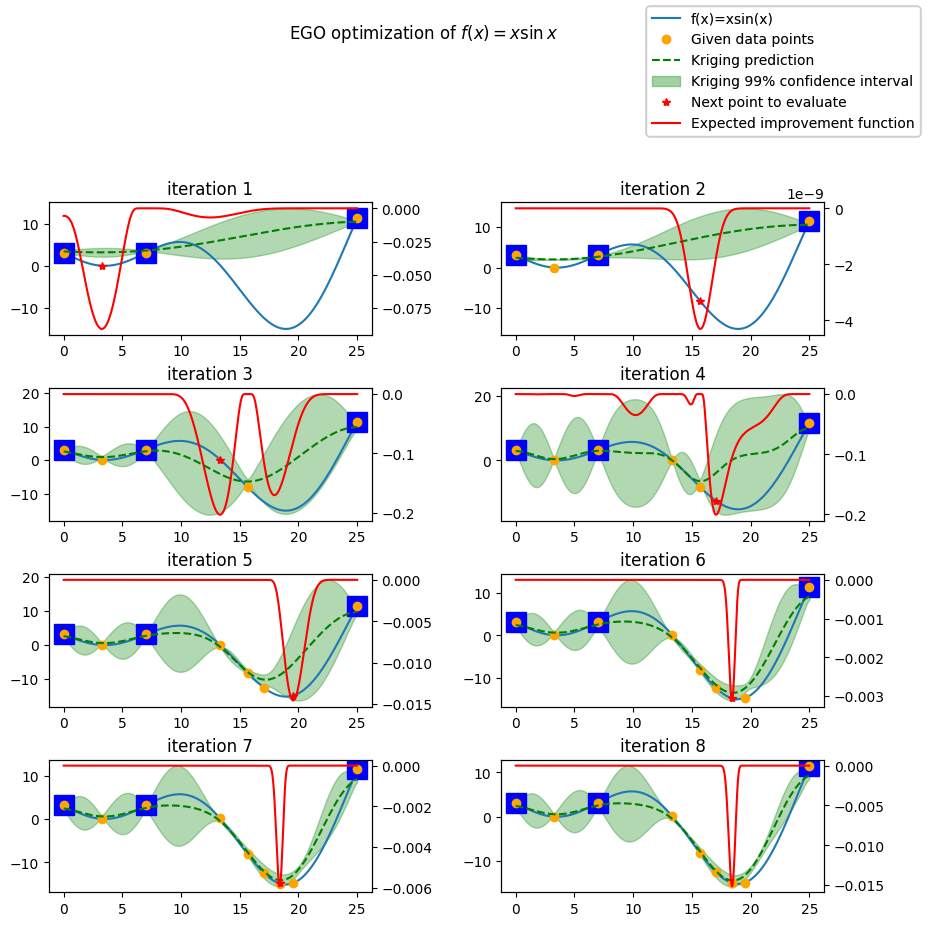

In [50]:
# Application of EGO (implementation of is_ri is already done)
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=surrogate,
    random_state=random_state,
    enable_tunneling=enable_tunneling,
    n_start=n_start,
    is_ri=is_ri,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun_1d)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(x_opt.item(), y_opt.item()))


fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(X_plot)
    y_gp_plot_var = ego.gpr.predict_variances(X_plot)
    y_ei_plot = -ego.EI(
        points=X_plot, enable_tunneling=enable_tunneling, x_data=x_data_k
    )
    # print(f"min {i+1}", y_ei_plot[0])
    # print(f"{i+1}ème itétation valeur EI minimale:", min(y_ei_plot))
    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(X_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(X_plot, Y_plot)
    # (doe,) = ax.plot(
    # xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue"
    # )
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    if i < n_iter - 1:
        (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(X_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \\sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvement function",
        ],
    )
plt.show()
# Check the optimal point is x_opt=18.9, y_opt =-15.1

So, we can clearly see now that the algorithm converges to the minimum as it used to do with noise-free Kriging.

## 2. Bayesian optimization with the Rosenbrock function: 2D

### 2.1. Rosenbrock function

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} \left[ 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2 \right] \quad \text{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$
x_i \in [-2, 2]
$$


In [51]:
# define the rosenbrock function
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n, dim = x.shape

    # parameters:
    Opt = []
    Opt_point_scalar = 1
    # construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    # Construction of Z vector
    Z = np.zeros((n, dim))
    for i in range(0, dim):
        Z[:, i] = x[:, i] - Opt[i] + 1

    # Sum
    sum1 = np.zeros((n, 1))
    for i in range(0, dim - 1):
        sum1[:, 0] += 100 * (((Z[:, i] ** 2) - Z[:, i + 1]) ** 2) + ((Z[:, i] - 1) ** 2)

    return sum1


xlimits = np.array([[-2, 2], [-2, 2]])

### 2.2. Noisy Gaussian Process without re-interpolation

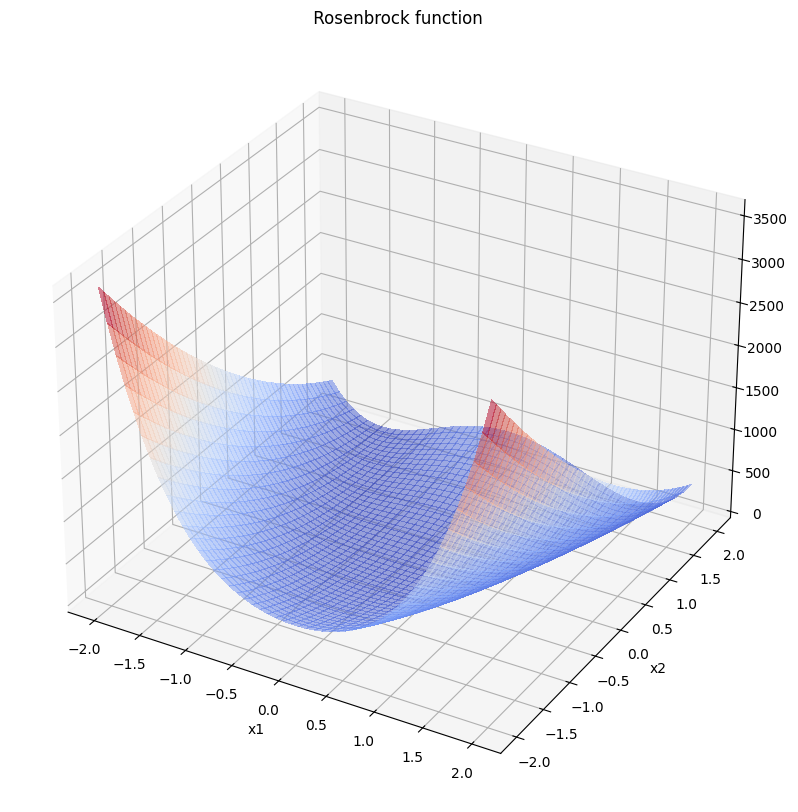

In [52]:
import matplotlib.pyplot as plt
from matplotlib import cm

# To plot the Rosenbrock function
num_plot = 50  # to plot rosenbrock
x = np.linspace(xlimits[0][0], xlimits[0][1], num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0, x1]])))
res = np.array(res)
res = res.reshape((50, 50)).T
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(
    X, Y, res, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5
)
plt.title(" Rosenbrock function")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [53]:
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

# number of points in the initial DOE
ndoe = 10  # (at least ndim+1)

# nois data
noise0 = [1e-1]

# number of iterations with EGO
n_iter = 15

design_space = DesignSpace(xlimits)

# Build the initial DOE, add the random_state option to have the reproducibility of the LHS points
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)


# EGO call
sm = KRG(
    design_space=design_space,
    n_start=20,
    print_global=False,
    noise0=noise0,
)
print("--- Let's take a look at the time taken for each iteration")
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=20,  # to do multistart for maximizing the acquisition function
)

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print("\n")

print("--- Let's take a look at the results")
print(
    "Xopt for Rosenbrock ",
    x_opt,
    "\nYopt for Rosenbrock",
    y_opt,
    " \nobtained using EGO criterion = ",
    criterion,
)
print("Check if the optimal point is Xopt= (1,1) with the Y value=0")
print(
    "if not you can increase the number of iterations with n_iter but the CPU will increase also."
)
print("---------------------------")

--- Let's take a look at the time taken for each iteration


--- Let's take a look at the results
Xopt for Rosenbrock  [0.98317194 1.01582788] 
Yopt for Rosenbrock [0.24235514]  
obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
if not you can increase the number of iterations with n_iter but the CPU will increase also.
---------------------------


### 2.3. Noisy Gaussian Process with re-interpolation

In [54]:
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

# number of points in the initial DOE
ndoe = 10  # (at least ndim+1)

# number of iterations with EGO
n_iter = 15

design_space = DesignSpace(xlimits)

# Build the initial DOE, add the random_state option to have the reproducibility of the LHS points
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)


# EGO call
sm = KRG(design_space=design_space, n_start=20, print_global=False, noise0=noise0)

print("--- Let's take a look at the time taken for each iteration")
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=20,  # to do multistart for maximizing the acquisition function
    is_ri=is_ri,
)


x_opt_ri, y_opt_ri, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print("\n")

print("--- Let's take a look at the results")
print(
    "Xopt for Rosenbrock ",
    x_opt_ri,
    "\nYopt for Rosenbrock",
    y_opt_ri,
    " \nobtained using EGO criterion = ",
    criterion,
)
print("Check if the optimal point is Xopt= (1,1) with the Y value=0")
print(
    "if not you can increase the number of iterations with n_iter but the CPU will increase also."
)
print("---------------------------")

--- Let's take a look at the time taken for each iteration


--- Let's take a look at the results
Xopt for Rosenbrock  [0.91977436 0.86120331] 
Yopt for Rosenbrock [0.02959622]  
obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
if not you can increase the number of iterations with n_iter but the CPU will increase also.
---------------------------


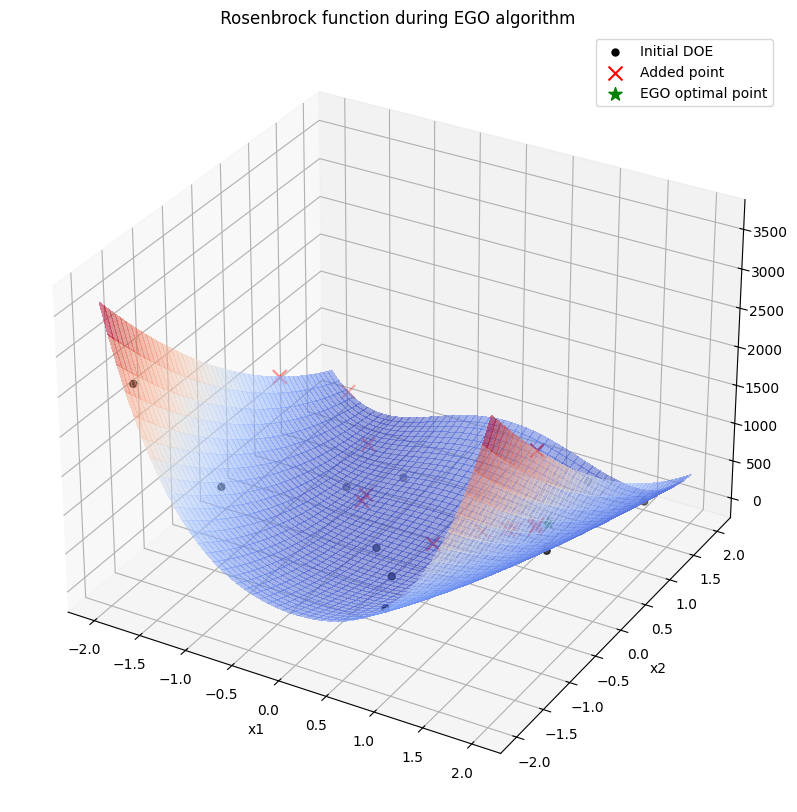

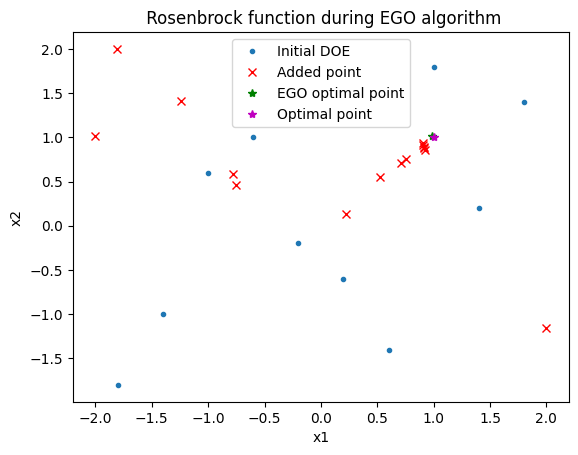

In [57]:
# To plot the Rosenbrock function
# 3D plot
x = np.linspace(xlimits[0][0], xlimits[0][1], num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0, x1]])))
res = np.array(res)
res = res.reshape((50, 50)).T
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

surf = ax.plot_surface(
    X, Y, res, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5
)
# to add the points provided by EGO
ax.scatter(
    x_data[:ndoe, 0],
    x_data[:ndoe, 1],
    y_data[:ndoe, 0],
    zdir="z",
    marker=".",
    c="k",
    s=100,
    label="Initial DOE",
)
ax.scatter(
    x_data[ndoe:, 0],
    x_data[ndoe:, 1],
    y_data[ndoe:, 0],
    zdir="z",
    marker="x",
    c="r",
    s=100,
    label="Added point",
)
ax.scatter(
    x_opt[0],
    x_opt[1],
    y_opt[0],
    zdir="z",
    marker="*",
    c="g",
    s=100,
    label="EGO optimal point",
)

plt.title(" Rosenbrock function during EGO algorithm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


# 2D plot
# to add the points provided by EGO
plt.plot(x_data[:ndoe, 0], x_data[:ndoe, 1], ".", label="Initial DOE")
plt.plot(x_data[ndoe:, 0], x_data[ndoe:, 1], "x", c="r", label="Added point")
plt.plot(x_opt[:1], x_opt[1:], "*", c="g", label="EGO optimal point")
plt.plot([1], [1], "*", c="m", label="Optimal point")

plt.title(" Rosenbrock function during EGO algorithm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

### 2.4. Comparison of the results with and without variance re-interpolation

In [58]:
print("x_opt", x_opt, "y_opt", y_opt, "\n")
print("x_opt_ri", x_opt_ri, "y_opt_ri", y_opt_ri)
print(f"The lower minimum is with the re-interpolation: {y_opt > y_opt_ri}")

x_opt [0.98317194 1.01582788] y_opt [0.24235514] 

x_opt_ri [0.91977436 0.86120331] y_opt_ri [0.02959622]
The lower minimum is with the re-interpolation: [ True]


We are glad to observe that in 2D as well, re-interpolation leads to better results in the same number of iterations and slightly faster (Cholesky decomposition is facilitated due to semi-positive definite matrices).